## Классификация временных рядов

Эта тетрадка содержит простые примеры классификации временных рядов с использованием библиотеки ETNA.

**Содержание**


* [Загрузка набора данных](#section_1)
* [Извлечение признаков](#section_2)
* [Оценка качества](#section_3)

**Формулировка задачи**: Дан набор временных рядов $\{x_i\}_{i=1}^{N}$ и соответствующие метки $\{y_i\}_{i=1}^{N}$. Нам необходимо найти классификатор, который может выучить взаимосвязь между временным рядом и меткой, и точно предсказать метку для нового ряда.

Библиотека ETNA представляет инструменты для бинарной классификации временных рядов в экспериментальном формате. Это подразумевает, что архитектура и API объектов из модуля `etna.experimental` могут претерпеть изменения в будущем.

### Загрузка набора данных <a class="anchor" id="section_1"></a>

Рассмотрим пример набора данных `FordA` из [архива UCR](https://www.cs.ucr.edu/~eamonn/time_series_data/). Набор данных состоит из измерений шума двигателя, и задача состоит в том, чтобы диагностировать наличие определенного симптома в двигателе. Полное описание набора данных `FordA` можно найти [здесь](http://www.timeseriesclassification.com/description.php?Dataset=FordA).

Для загрузки набора данных мы воспользуемся функцией `fetch_ucr_dataset()` из [библиотеки `pyts`](https://pyts.readthedocs.io/en/stable/index.html).

In [1]:
# импортируем функцию для загрузки и модуль библиотеки 
# matplotlib для визуализации набора данных
from pyts.datasets.ucr import fetch_ucr_dataset
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
# набор данных уже разделен на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = fetch_ucr_dataset(
    dataset='FordA', return_X_y=True)

# изначальную кодировку классов -1,1 заменяем на кодировку 0,1
y_train[y_train == -1], y_test[y_test == -1] = 0, 0

In [3]:
# каждый ряд в наборе данных содержит 500 
# точек измерения шума двигателя
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3601, 500), (1320, 500), (3601,), (1320,))

Давайте визуализируем по одному ряду для каждого класса.

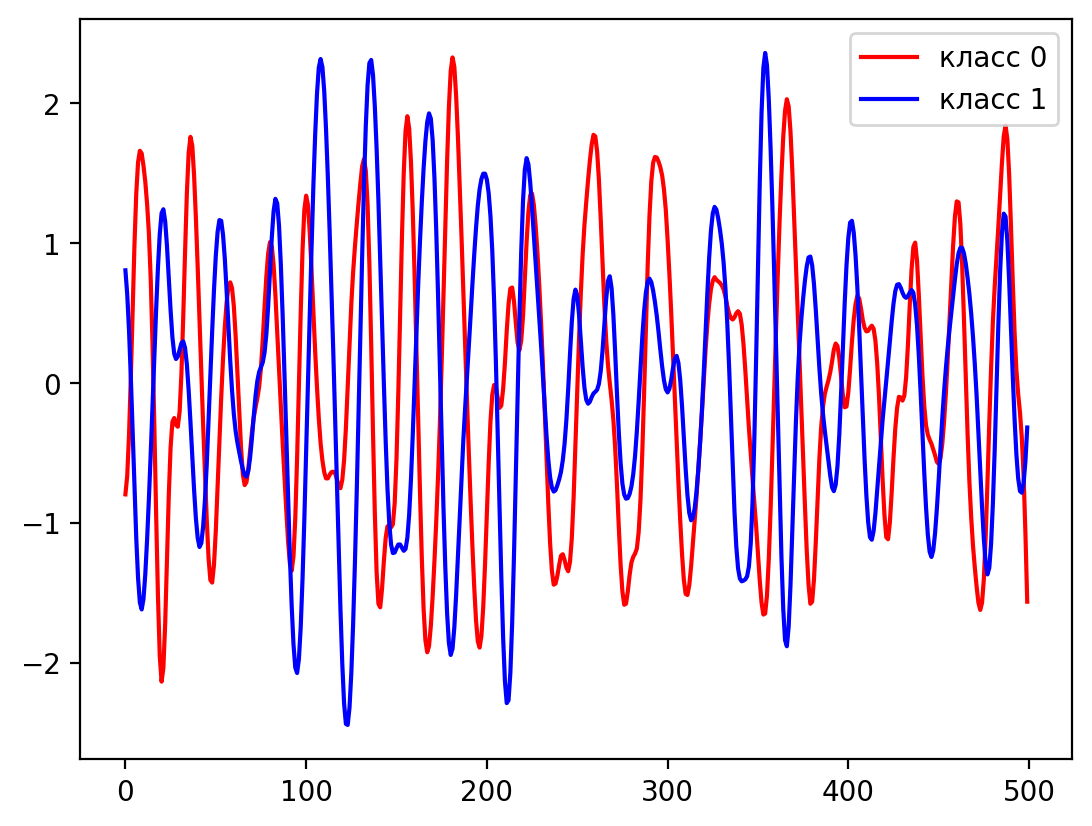

In [4]:
# визуализируем по одному ряду для каждого класса
for c in [0, 1]:
    class_samples = X_train[y_train == c]
    plt.plot(class_samples[0], label='класс ' + str(c), c=['r', 'b'][c])
plt.legend(loc='best');

### Извлечение признаков <a class="anchor" id="section_2"></a>

Необработанные значения временных рядов обычно не являются лучшими признаками для классификатора. Длина ряда обычно намного больше, чем количество наблюдений в наборе данных, и в этом случае классификаторы работают плохо. Существуют специальные методы извлечения более информативных признаков из временных рядов, их исчерпывающий обзор вы можете найти в этой [статье](https://hal.inria.fr/hal-03558165/document).

Библиотека предлагает два метода извлечения признаков, способных работать с временными рядами различной длины
1. `TSFreshFeatureExtractor` - извлекает признаки с помощью функции `extract_features()` из библиотеки [tsfresh](https://tsfresh.readthedocs.io/en/latest/)

In [5]:
# импортируем класс TSFreshFeatureExtractor, 
# извлекающий признаки с помощью tsfresh
from etna.experimental.classification.feature_extraction import (
    TSFreshFeatureExtractor)

In [6]:
# импортируем класс MinimalFCParameters
from tsfresh.feature_extraction.settings import MinimalFCParameters

In [7]:
# настраиваем способ извлечения признаков с помощью tsfresh, 
# выбрав минимальный базовый набор признаков 
# и заменив пустые значения на -100
tsfresh_feature_extractor = TSFreshFeatureExtractor(
    default_fc_parameters=MinimalFCParameters(), 
    fill_na_value=-100)

2. `WEASELFeatureExtractor` -- извлекает признаки с помощью алгоритма WEASEL, см. [оригинальную статью](https://arxiv.org/pdf/1701.07681.pdf)

Этот метод имеет длинный список параметров, наиболее важными из которых являются:
- **padding_value** -- значение для заполнения ряда в тестовом наборе так, чтобы он соответствовал кратчайшему ряду в обучающем наборе
- **word_size**, **n_bins** -- размер слова и размер алфавита для аппроксимации ряда (сильно влияет на качество)
- **window_sizes** -- размеры скользящих окон
- **window_steps** -- шаги окон
- **chi2_threshold** -- порог отбора признаков (чем выше порог, тем меньше признаков отбирается)

In [8]:
# импортируем класс TSFreshFeatureExtractor, 
# извлекающий признаки с помощью WEASEL
from etna.experimental.classification.feature_extraction import (
    WEASELFeatureExtractor)

In [9]:
# настраиваем способ извлечения признаков с помощью WEASEL
weasel_feature_extractor = WEASELFeatureExtractor(
    padding_value=-10,
    word_size=4,
    n_bins=4,
    window_sizes=[0.2, 0.3, 0.5, 0.7, 0.9],
    window_steps=[0.1, 0.15, 0.25, 0.35, 0.45],
    chi2_threshold=2
)

### Оценка качества  <a class="anchor" id="section_3"></a>

Чтобы оценить качество наших методов извлечения признаков, мы будем использовать метод `masked_crossval_score` класса `TimeSeriesBinaryClassifier`.

In [10]:
# импортируем класс TimeSeriesBinaryClassifier
# для выполнения бинарной классификации рядов
from etna.experimental.classification import (
    TimeSeriesBinaryClassifier)
# импортируем класс-классификатор (строит 
# модель логистической регрессии)
from sklearn.linear_model import LogisticRegression

Во-первых, нам нужно создать экземпляр класса `TimeSeriesBinaryClassifier`, для чего требуется задать метод извлечения признаков и модель классификации с интерфейсом sklearn.

In [11]:
# создаем классификатор (модель логистической регрессии)
model = LogisticRegression(max_iter=1000)
# создаем классификатор рядов, передав метод
# извлечения признаков с помощью tsfresh и
# модель-классификатор
clf = TimeSeriesBinaryClassifier(
    feature_extractor=tsfresh_feature_extractor, 
    classifier=model)

In [12]:
# импортируем класс KFold и библиотеку NumPy
from sklearn.model_selection import KFold
import numpy as np

Затем нам нужно подготовить маски блоков перекрестной проверки.

In [13]:
# создаем маску с индексами блоков
mask = np.zeros(len(X_train))
for fold_idx, (train_index, test_index) in enumerate(
    KFold(n_splits=5).split(X_train)):
    mask[test_index] = fold_idx

Затем мы можем запустить перекрестную проверку и оценить качество на 5 блоках.

In [14]:
# вычисляем метрики классификации 
# по блокам перекрестной проверки
metrics = clf.masked_crossval_score(x=X_train, 
                                    y=y_train, 
                                    mask=mask)

Feature Extraction: 100%|███████████████████| 720/720 [00:00<00:00, 3816.96it/s]


Возвращаемый словарь `metrics` содержит набор стандартных метрик классификациии для каждого блока перекрестной проверки.

In [15]:
# выводим метрики классификации по
# блокам перекрестной проверки
metrics

{'precision': [0.5383522727272727,
  0.5160048049745619,
  0.5422891046203586,
  0.48479549208199746,
  0.5564688579909953],
 'recall': [0.531589156237011,
  0.5139824524851263,
  0.538684876779783,
  0.4855088120003704,
  0.5484257847863261],
 'fscore': [0.511929226858391,
  0.497349709114415,
  0.5324451810300866,
  0.4796875,
  0.5365782570679103],
 'AUC': [0.5555427269508459,
  0.5453465132609517,
  0.5570033834266291,
  0.5186734158461681,
  0.5629105765287568]}

In [16]:
# выводим метрики классификации, усредненные 
# по блокам перекрестной проверки
{metric: np.mean(values) for metric, values in metrics.items()}

{'precision': 0.5275821064790372,
 'recall': 0.5236382164577233,
 'fscore': 0.5115979748141605,
 'AUC': 0.5478953232026702}

Первый метод извлечения признаков показывает плохое качество на этом наборе данных. Попробуем второй метод.

In [17]:
# создаем классификатор рядов, передав метод
# извлечения признаков с помощью WEASEL и
# модель-классификатор
clf = TimeSeriesBinaryClassifier(
    feature_extractor=weasel_feature_extractor, 
    classifier=model)
# вычисляем метрики классификации 
# по блокам перекрестной проверки
metrics = clf.masked_crossval_score(x=X_train, 
                                    y=y_train, 
                                    mask=mask)

In [18]:
# выводим метрики классификации по
# блокам перекрестной проверки
metrics

{'precision': [0.8489879944589811,
  0.8723519197376037,
  0.8526994807058697,
  0.8640069169960474,
  0.8791666666666667],
 'recall': [0.8490470912421682,
  0.8723059471722574,
  0.8539010057371147,
  0.8638383900737677,
  0.8802257832388056],
 'fscore': [0.848819918551392,
  0.8722212362749713,
  0.8526401964797381,
  0.863862627821725,
  0.8790824629033722],
 'AUC': [0.931510645176188,
  0.9457061061339138,
  0.9299235825610295,
  0.9476758541930307,
  0.9500847267465704]}

In [19]:
# выводим метрики классификации, усредненные 
# по блокам перекрестной проверки
{metric: np.mean(values) for metric, values in metrics.items()}

{'precision': 0.8634425957130338,
 'recall': 0.8638636434928226,
 'fscore': 0.8633252884062397,
 'AUC': 0.9409801829621465}

Как можно увидеть, качество, получаемое после извлечения признаков, сильно зависит от предметной области задачи, поэтому хорошей практикой является сравнение нескольких методов на вашей задаче.